In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import os
import random
import matplotlib.pyplot as plt
import numpy as np

C:\Users\zhi12\.conda\envs\GCN_STUDY\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" device: {device}")
device = "cpu"

 device: cuda


## DATA SET

In [3]:
def load_data(root, batch_size):
    mnist_train = torchvision.datasets.MNIST(root=root,
                                             transform=transforms.ToTensor(),
                                             train=True,
                                             download=True)

    mnist_test = torchvision.datasets.MNIST(root=root,
                                            transform=transforms.ToTensor(),
                                            train=False,
                                            download=True)

    data_loader = DataLoader(dataset=mnist_train,
                             batch_size=batch_size,
                             shuffle=True,
                             drop_last=True)

    return data_loader, mnist_train, mnist_test

root = "./DATA"
batch_size = 100
data_loader, mnist_train, mnist_test = load_data(root, batch_size)

## MODEL

In [42]:
"""
VAE = Encoder + Sampling

Encoder:
    x = input = [**, 1, 28, 28]
    cnn1(x) = [**, 32, 13, 13]
    cnn2(x) = [**, 64, 5, 5]
    cnn3(x) = [**, 128, 1, 1]


Sampling:
    x = [**, 128, 1, 1]
    mu = [**, 128, 1, 1]
    log_var = [**, 128, 1, 1]

Decoder:
    x = [**, 128, 1, 1]
    cnn1(x) = [**, 64, 3, 3]
    cnn2(x) = [**, 32, 7, 7]
    cnn3(x) = [**, 16, 14, 14]
    cnn4(x) = [**, 1, 28, 28]
"""


class Encoder(nn.Module):
    def __init__(self, in_channels, z_dim):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=z_dim//4,
                      kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2, 2),
            nn.ReLU()
        )
        
        self.cnn2 = nn.Sequential(
            nn.Conv2d(in_channels=z_dim//4, out_channels=z_dim//2,
                      kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2, 2),
            nn.ReLU()
        )
        
        self.cnn3 = nn.Sequential(
            nn.Conv2d(in_channels=z_dim//2, out_channels=z_dim,
                      kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2, 2),
            nn.ReLU()
        )
        
        self.mu_layer = nn.Conv2d(in_channels=z_dim, out_channels=z_dim,
                      kernel_size=1, stride=1, padding=0)
        
        self.var_layer = nn.Conv2d(in_channels=z_dim, out_channels=z_dim,
                      kernel_size=1, stride=1, padding=0)
    
    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        
        mu = self.mu_layer(x)
        log_var = self.var_layer(x)
        
        return mu, log_var
    
class Decoder(nn.Module):
    def __init__(self, z_dim, out_channels):
        super().__init__()
        
        self.cnn1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_dim, out_channels=z_dim//2,     
                               kernel_size=3, stride=2, padding=0),
            nn.ReLU()
            )
        
        self.cnn2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_dim//2, out_channels=z_dim//4,     
                               kernel_size=3, stride=2, padding=0),
            nn.ReLU()
            )
        
        self.cnn3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_dim//4, out_channels=z_dim//8,     
                               kernel_size=2, stride=2, padding=0),
            nn.ReLU()
            )
        
        self.cnn4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_dim//8, out_channels=out_channels,     
                               kernel_size=2, stride=2, padding=0)
        )
        
    def forward(self, x):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = torch.sigmoid(x)
        return x
    
class VAE(nn.Module):
    def __init__(self, in_channels, z_dim, out_channels):
        super().__init__()
        self.encoder = Encoder(in_channels=in_channels, z_dim=z_dim)
        self.decoder = Decoder(z_dim=z_dim, out_channels=out_channels)
        
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [47]:
model = VAE(in_channels=1, z_dim=128, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters())

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

cnt = 0

epoch = 1
for i in range(1, epoch+1):
    print(f"epoch: {i:02}/{epoch}")
    model.train()
    train_loss = 0
    for x, _ in data_loader:
        x = x.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(x)
        loss = loss_function(recon_batch, x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        print(end="")

        if cnt%10==0:
            print(f'\r{cnt/len(data_loader):.1%}', end="")        
        cnt+=1    
        
    cnt=0
    print("\r", end="")
    
print("finished")
        
    

epoch: 01/1
finished


## CHECK PERFORMANCE

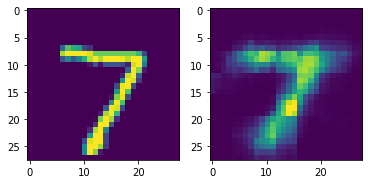

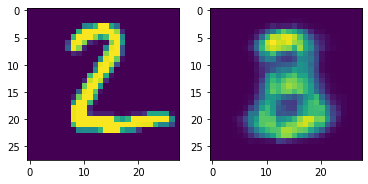

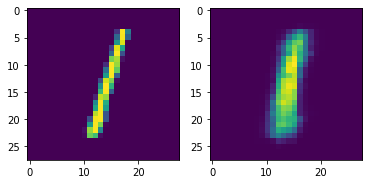

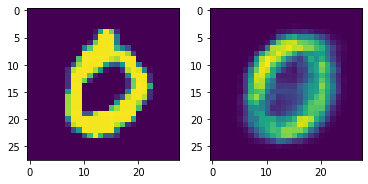

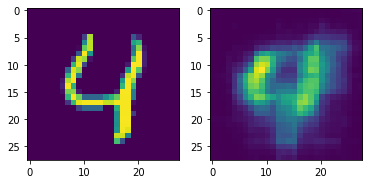

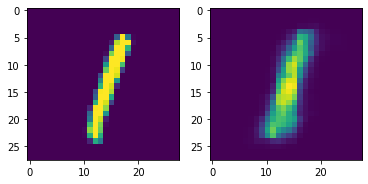

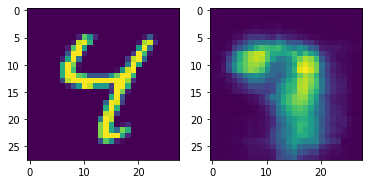

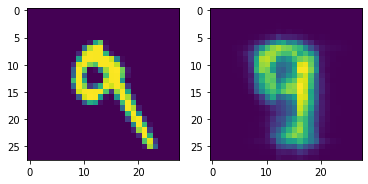

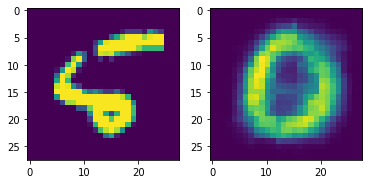

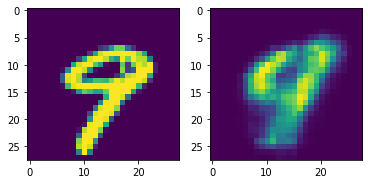

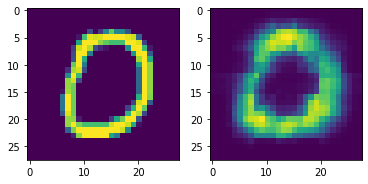

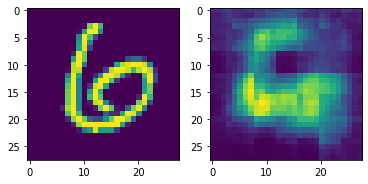

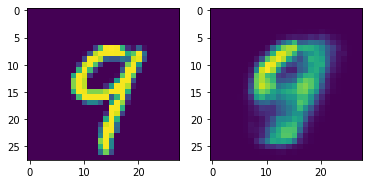

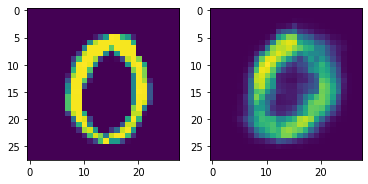

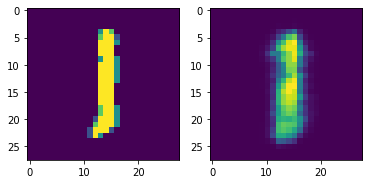

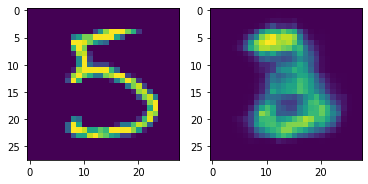

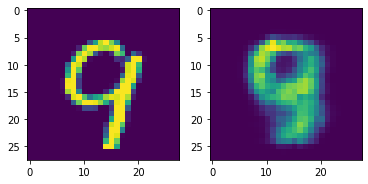

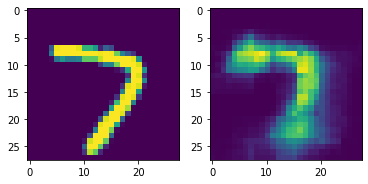

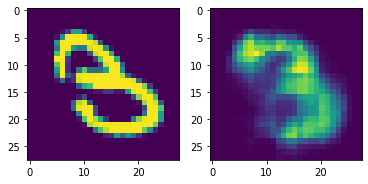

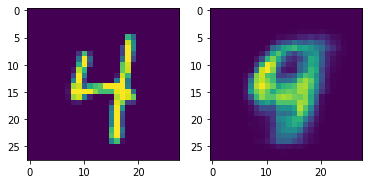

In [48]:
# check performance
model.eval()
times = 20
for i in range(times):
    # call data
    x, y = mnist_test[i]
    x_p, _, _ = model(x)  
    
    # resize
    x = x.view(28, 28)
    x_p = x_p.detach().numpy().reshape(28,28)
    
    # plot
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(x)
    axs[1].imshow(x_p)
    